In [19]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.integrate import quad
import csv

In [20]:
# ha_list = [('8133-12705', 0.130943), ('8256-12704', 0.12611), ('8616-3703', 0.135063),
#              ('8720-12702', 0.134953), ('8721-3701', 0.118101)]
# #('8137-9101', 0.118865),

# ha_list_uncertain = ['8155-6103(?)', '8254-6103(?)', '8338-12705(?)', '8606-12704(?)']

# ha_list2 = [('7815-6103', 0.135043), ('7991-12705', 0.113153), ('7992-9102', 0.119399), ('8132-6101', 0.129403),
#              ('8132-12703', 0.116056), ('8133-12704', 0.134471), ('8137-3702', 0.131997),
#              ('8143-6101', 0.126168), ('8244-12704', 0.115137), ('8318-6102', 0.12908), ('8329-6102', 0.142887),
#              ('8439-3703', 0.138619), ('8448-3703', 0.138746), ('8464-6101', 0.125582), ('9049-1901', 0.131457)]

# obj1_43214 = [('8135-1902', 0.117997)]

# ha_list2_uncertain = ['8454-6102(?)', '8552-9102(?)', '8717-1902(?)']

problems = [('7991-12705', 0.113153), ('8132-6101', 0.129403), ('8244-12704', 0.115137)]

outlier = [('8616-3703', 0.135063), ('7992-9102', 0.119399), ('8318-6102', 0.12908)]

ha_list = [('8133-12705', 0.130943), ('8256-12704', 0.12611), ('8720-12702', 0.134953), 
           ('8721-3701', 0.118101), ('7815-6103', 0.135043),  ('8132-12703', 0.116056), 
           ('8133-12704', 0.134471), ('8137-3702', 0.131997), ('8143-6101', 0.126168),  
           ('8329-6102', 0.142887), ('8439-3703', 0.138619), ('8448-3703', 0.138746), ('8464-6101', 0.125582), 
           ('9049-1901', 0.131457)]

In [21]:
def spectrum_gen(flux, ivar):    
    n = len(flux)
    sumflux = np.zeros(4563)

    for i in range(n):
        for j in range(n):
            flux_ = flux[i,j] * ~do_not_use[i,j]
            flux_filtered = sigma_gen_compare(ivar[i,j], flux_)
            sumflux = np.add(sumflux, flux_)
    return sumflux

In [22]:
def sigma_gen_compare(ivar, flux_masked):
    
    # change ivar array to sigma array 
    
    sigma = np.sqrt(np.abs(np.divide(1, ivar, where = ivar != 0)))
#     print(sigma)
    
    is_less_than_3sigma = flux_masked < 3 * sigma # compare the sigma array 
#     print(flux_masked)
#     print(is_less_than_3sigma)
        
    flux_masked_filtered = flux_masked * ~is_less_than_3sigma # multiply the truth value
    
    return flux_masked_filtered

In [23]:
def gaussian(x, amp, mean, sigma, base):
    return (amp * np.exp(-(x-mean)**2 / (2*sigma**2))) + base

In [24]:
def area_finder(x, y):
#     print('x',x)
#     print('y',y)
    dlmd = (x[-1] - x[0])/len(x)
#     print(dlmd)
        
    area = (1/2)*(dlmd)*(y[0] + y[-1] + np.sum(2*(y[1:-1])))
#     print('area', area)

    subtract = y[0] * (x[-1] - x[0])

    subtracted_area = area - subtract
#     print(subtracted_area)
    
    return subtracted_area

In [25]:
c = (3*(10**5)) # speed of light in km/s
l_ha = 6563 # H-alpha wavelength

6563 6548 6583

amp 132.64463887741528
mean 7424.838495565586
sigma 2.8115586277464084
base 89.97116904694553
new_amp 222.6158079243608

Flux + continuum = 2934.1732190578587
Continuum 1999.4592927375518
Flux = 934.7139263203069


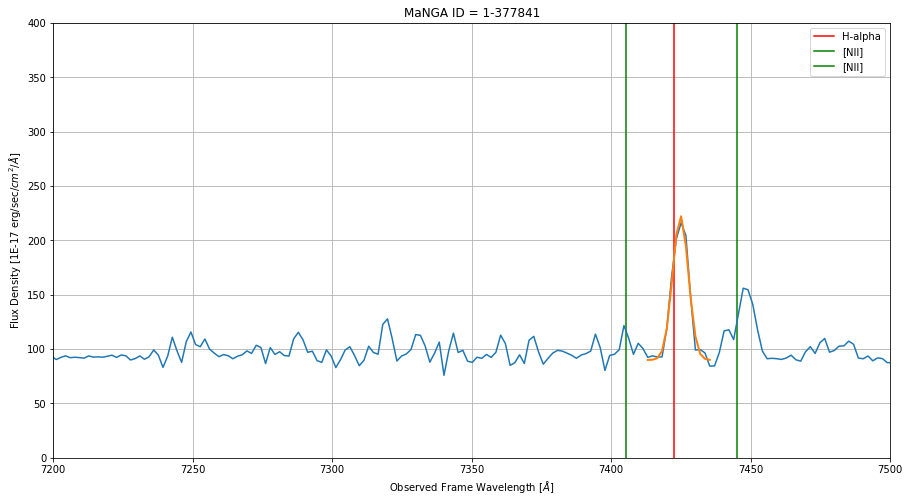

amp 56.40043893342369
mean 7391.875138890323
sigma 3.57748720115682
base 166.19894755593415
new_amp 222.59938648935784

Flux + continuum = 4182.132167016895
Continuum 3677.3712166695645
Flux = 504.7609503473309


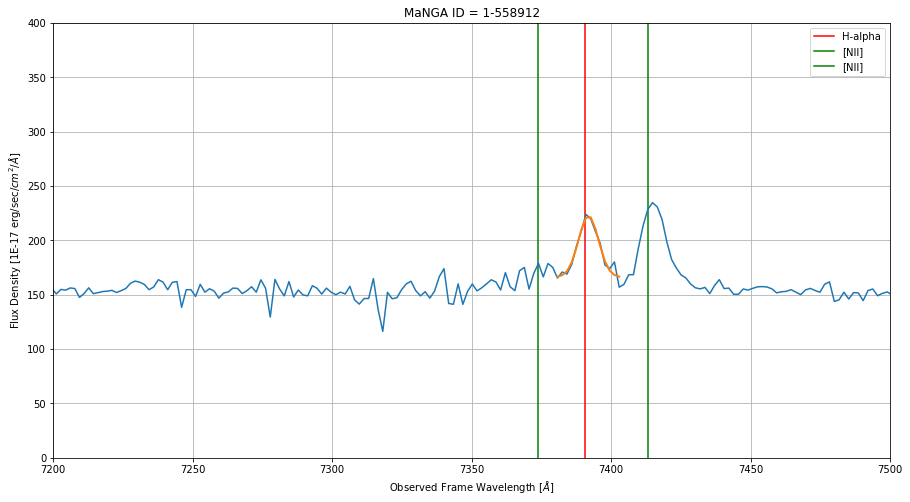

amp 53.29742346610265
mean 7451.367338006712
sigma 3.9719106090442793
base 86.30382347168975
new_amp 139.6012469377924

Flux + continuum = 2450.9152201871784
Continuum 1924.594496653446
Flux = 526.3207235337325


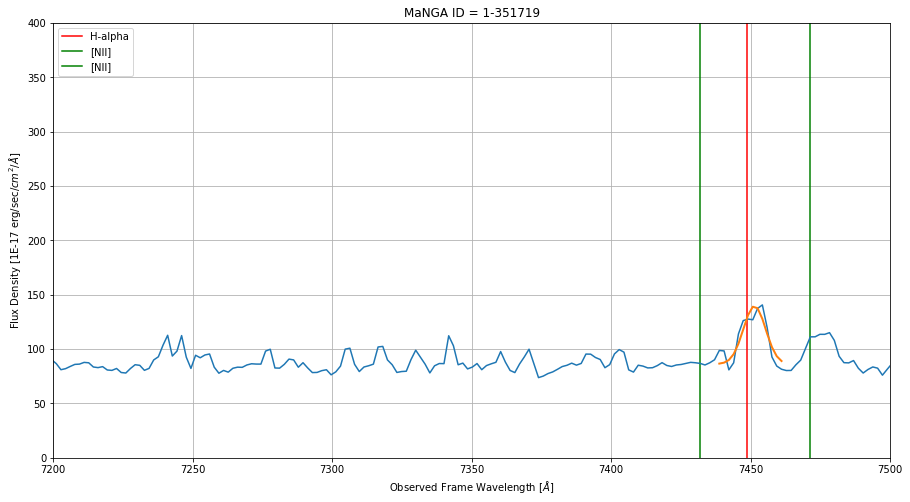

amp 109.69773985034269
mean 7340.69843572617
sigma 3.4939744803626835
base 89.88197522513113
new_amp 199.5797150754738

Flux + continuum = 2932.077166263842
Continuum 1974.6121773034752
Flux = 957.464988960367


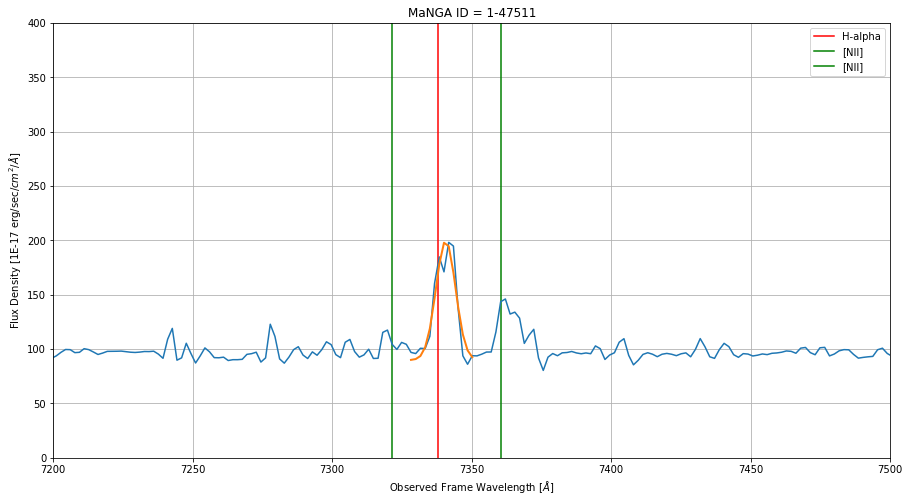

amp 250.78229847939815
mean 7451.165761826685
sigma 2.901719575443728
base 67.72092346314717
new_amp 318.50322194254534

Flux + continuum = 3217.4508449042933
Continuum 1394.183519085491
Flux = 1823.2673258188022


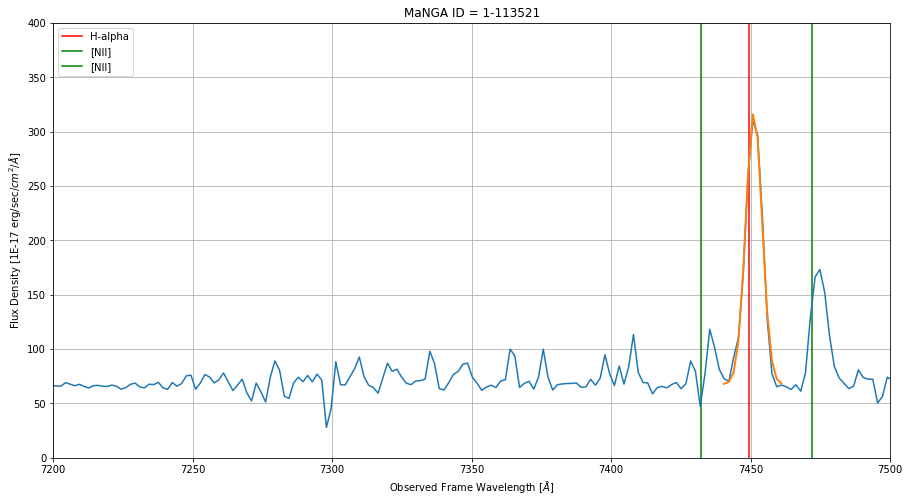

amp 310.4273138449136
mean 7327.424144683661
sigma 3.076052506452689
base 99.28118422762853
new_amp 409.70849807254217

Flux + continuum = 4567.4861423750435
Continuum 2177.0888418803656
Flux = 2390.397300494678


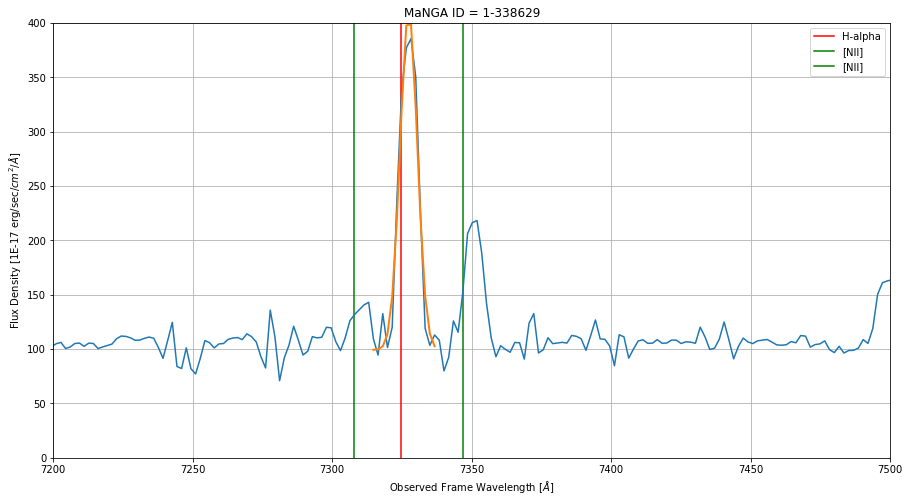

amp 34.241849358537095
mean 7445.656576427576
sigma 3.894306566853148
base 104.05039681517658
new_amp 138.2922461737137

Flux + continuum = 2470.523019769974
Continuum 2141.119041166917
Flux = 329.40397860305666


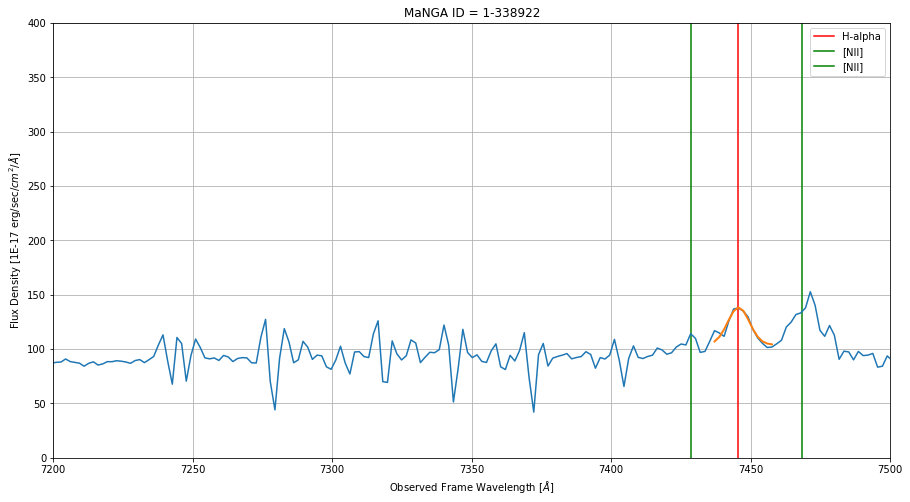

amp 60.6121424003056
mean 7433.076305727725
sigma 3.964765483412493
base 94.04260139905536
new_amp 154.65474379936097

Flux + continuum = 2687.426427840627
Continuum 2091.8658842985787
Flux = 595.5605435420484


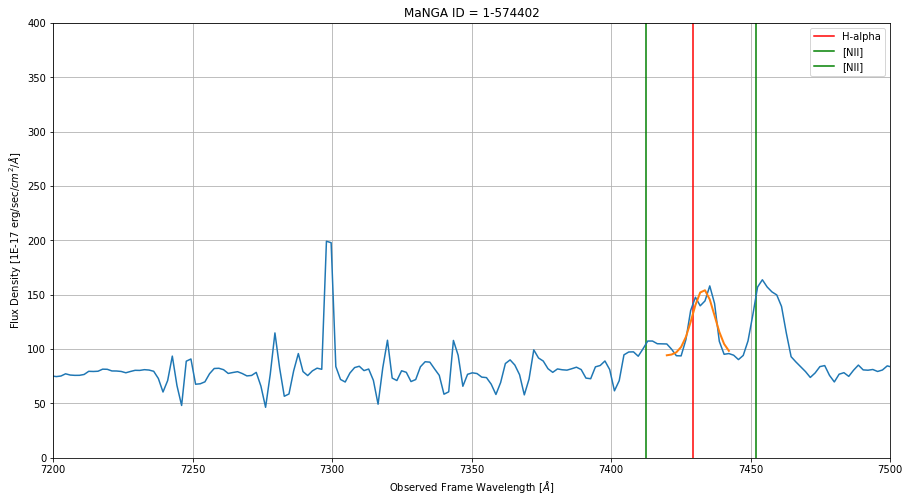

amp 85.55123490914175
mean 7393.425777169515
sigma 3.269274627833882
base 170.70455590959108
new_amp 256.25579081873286

Flux + continuum = 4186.369961725636
Continuum 3486.921617610293
Flux = 699.4483441153429


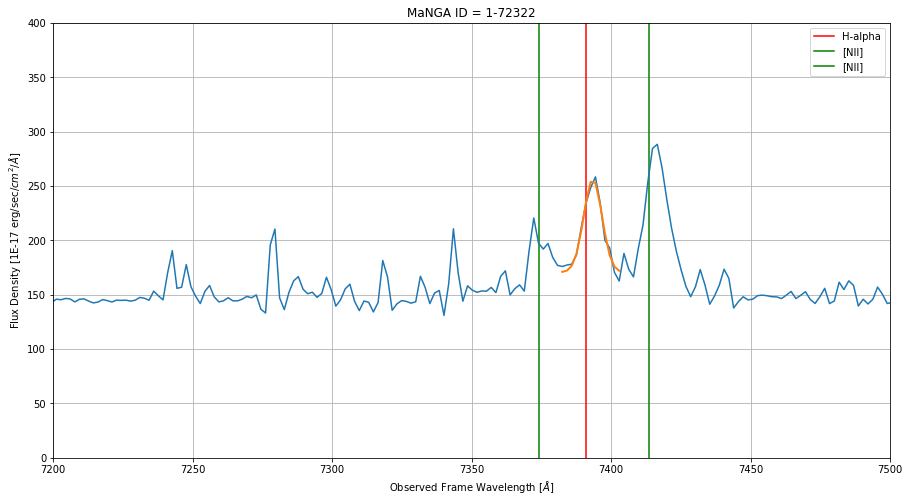

amp 63.91469872131729
mean 7505.070323635633
sigma 6.842591793859446
base 86.9345444496372
new_amp 150.84924317095448

Flux + continuum = 2724.4100660992494
Continuum 1802.1438561864538
Flux = 922.2662099127956


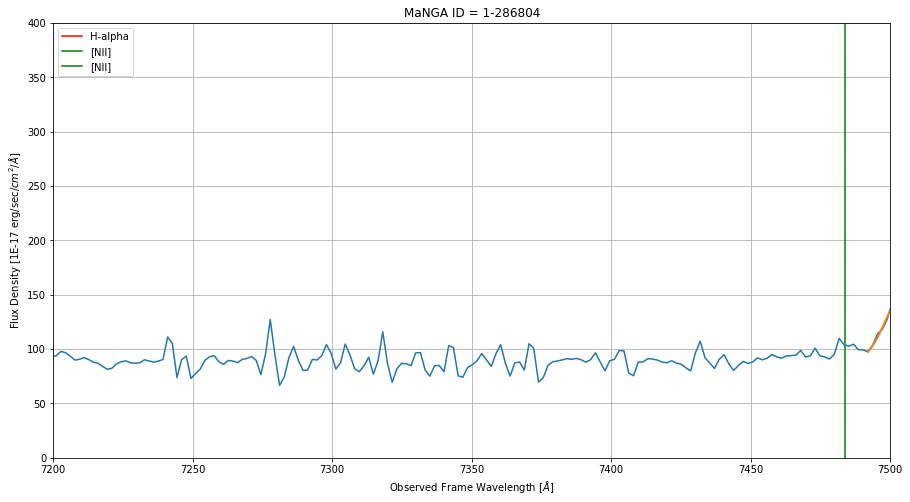

amp 175.07012384912008
mean 7475.055805234947
sigma 3.137940897892503
base 75.83509681052709
new_amp 250.90522065964717

Flux + continuum = 3072.677233043165
Continuum 1696.5999453112013
Flux = 1376.0772877319637


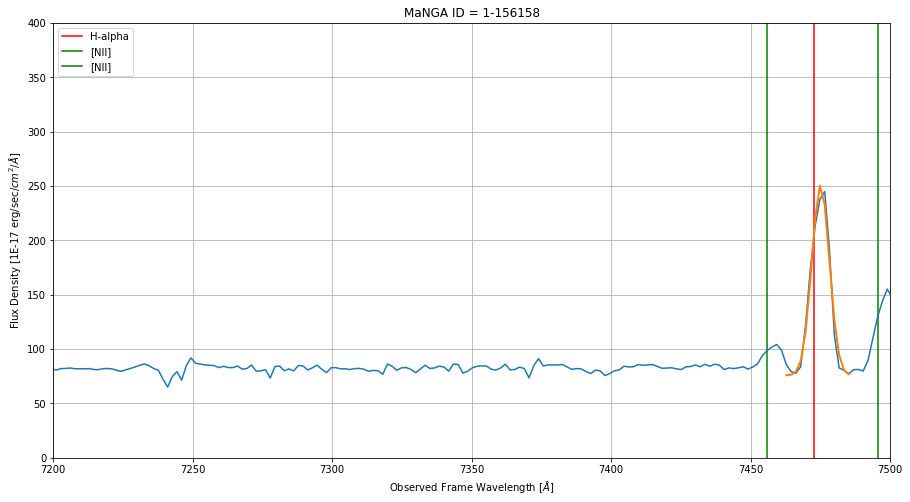

amp 155.33822209396362
mean 7473.092355550764
sigma 3.871030708087939
base 110.87885654259479
new_amp 266.2170786365584

Flux + continuum = 3968.4153445996717
Continuum 2481.178114112091
Flux = 1487.2372304875807


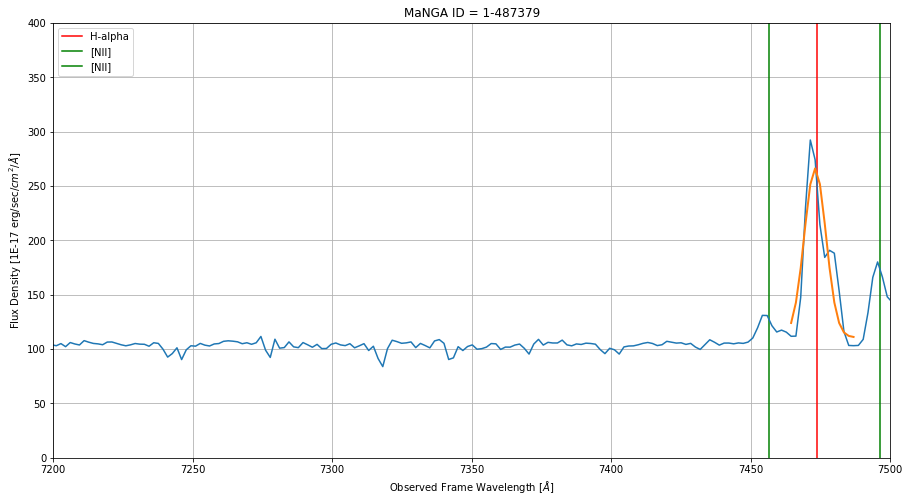

amp 270.42526270035773
mean 7389.4509291029035
sigma 4.159227006599102
base 105.70435737463885
new_amp 376.1296200749966

Flux + continuum = 5129.3353616331315
Continuum 2337.771681020426
Flux = 2791.5636806127054


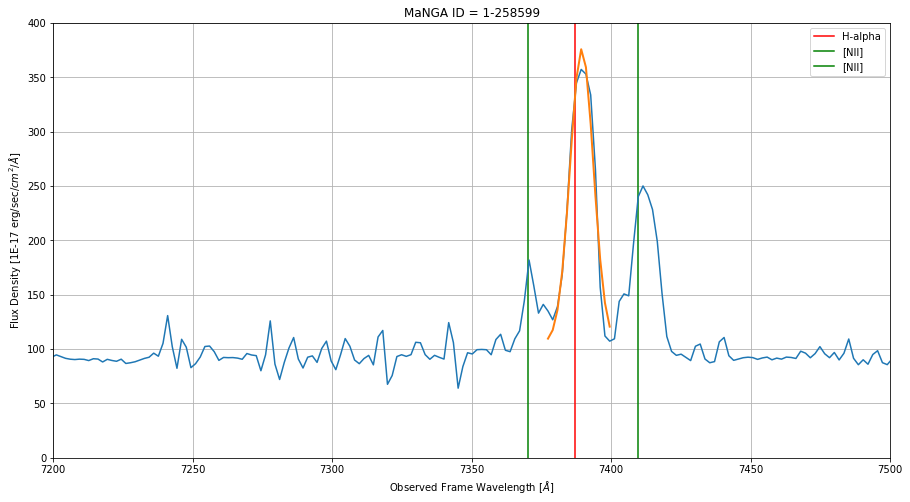

amp 198.5504040942874
mean 7427.435802848861
sigma 2.8109642848259946
base 95.70362174085055
new_amp 294.25402583513795

Flux + continuum = 3526.716188879823
Continuum 2127.8331783713656
Flux = 1398.8830105084576


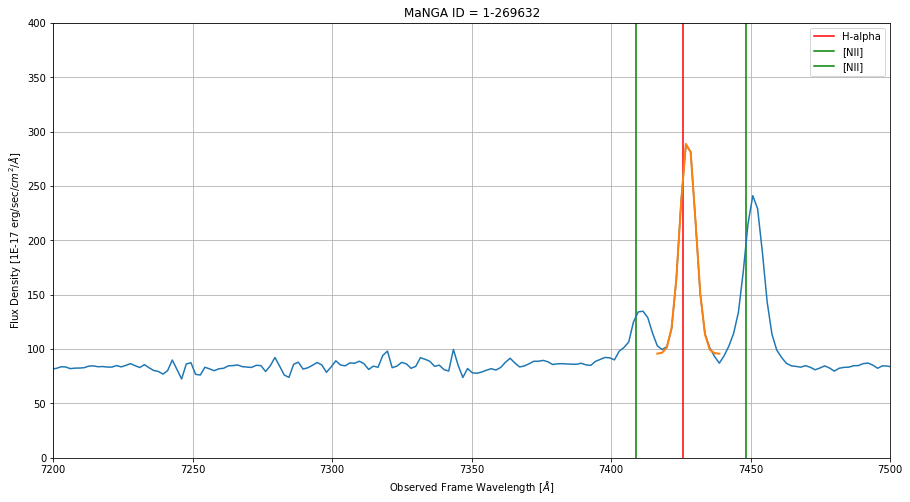

In [26]:
header = ['mangaid', 'plateifu', 'nsa_z', 'flux', 'FWHM km/s']
f = open('ha_list.csv', 'w', encoding='UTF8', newline='')
writer = csv.writer(f)

writer.writerow(header)

for plateifu in ha_list:
#     print(plateifu)
    data = fits.open(f'/Volumes/WD_External/All_Objects/manga-{plateifu[0]}-LOGCUBE.fits.gz')
    mangaid = data[0].header['MANGAID']

    flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

    ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

    mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))

    do_not_use = (mask & 2**10) != 0 

    wave = data['WAVE'].data

    sumflux = spectrum_gen(flux, ivar)

    peak_ha = 6563 * (1 + plateifu[1])
    peak_6548 = 6548 * (1 + plateifu[1])
    peak_6583 = 6583 *(1 + plateifu[1])
#     print(peak) 
    bound_ha = np.where(np.logical_and(wave > peak_ha-10, wave < peak_ha+15))

    idx_6548 = np.where(wave < peak_6548)
    idx_6583 = np.where(wave > peak_6583)

    base_6548 = sumflux[idx_6548[0][-50] : idx_6548[0][-1]+1]
    base_6583 = sumflux[idx_6583[0][0] : idx_6583[0][50]]
    base_total = np.mean(base_6548 + base_6583)

#         bound_6548 = np.where(np.logical_and(wave > peak_6548-10, wave < peak_6548+10))
#         bound_6583 = np.where(np.logical_and(wave > peak_6583-10, wave < peak_6583+18))

#     print('bound', bound_6548, bound_6583)

    lb_ha = bound_ha[0][0]
    ub_ha = bound_ha[0][-1]

#         lb_6548 = bound_6548[0][0]
#         ub_6548 = bound_6548[0][-1] 

#         lb_6583 = bound_6583[0][0]
#         ub_6583 = bound_6583[0][-1] 

#     print(lb_6548, ub_6548, lb_ha, ub_ha, lb_6583, ub_6583)
#     print(wave[lb_6548], wave[ub_6548], wave[lb_ha], wave[ub_ha], wave[lb_6583], wave[ub_6583])

    sumflux_slice_ha = sumflux[lb_ha : ub_ha]
#         sumflux_slice_6548 = sumflux[lb_6548 : ub_6548]
#         sumflux_slice_6583 = sumflux[lb_6583 : ub_6583]

#     sumflux_slice = sumflux[lb_6548 : ub_6583]

#     print('sumflux_slice',sumflux_slice)

    wave_slice_ha = wave[lb_ha : ub_ha]
#         wave_slice_6548 = wave[lb_6548 : ub_6548]
#         wave_slice_6583 = wave[lb_6583 : ub_6583]

#     wave_slice = wave[lb_6548 : ub_6583]

#     print('wave_slice', wave_slice)

    amp_ha = max(sumflux_slice_ha)
    mean_ha = peak_ha
    sigma_ha = np.std(wave_slice_ha)
    base_ha = min(sumflux_slice_ha)

#         amp_6548 = max(sumflux_slice_6548)
#         mean_6548 = peak_6548
#         sigma_6548 = np.std(wave_slice_6548)
#         base_6548 = min(sumflux_slice_6548)

#         amp_6583 = max(sumflux_slice_6583)
#         mean_6583 = peak_6583
#         sigma_6583 = np.std(wave_slice_6583)
#         base_6583 = min(sumflux_slice_6583)

#     base = min(sumflux_slice)

#     p0_ = [amp_ha, amp_6548, amp_6583,
#            mean_ha, mean_6548, mean_6583,
#            sigma_ha, sigma_6548, sigma_6583,
#            base]

#         p0_ha = [amp_ha, mean_ha, sigma_ha, base_ha]
    p0_ha = [amp_ha, mean_ha, sigma_ha, base_total]

#         p0_6548 = [amp_6548, mean_6548, sigma_6548, base_6548]
#         p0_6583 = [amp_6583, mean_6583, sigma_6583, base_6583]

    popt_ha, pcov_ha = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, p0 = p0_ha)
#         popt_6548, pcov_6548 = curve_fit(gaussian, wave_slice_6548, sumflux_slice_6548, p0 = p0_6548)
#         popt_6583, pcov_6583 = curve_fit(gaussian, wave_slice_6583, sumflux_slice_6583, p0 = p0_6583)

    print('amp', popt_ha[0])
    print('mean', popt_ha[1])
    print('sigma', popt_ha[2])
    print('base', popt_ha[3])
    new_amp = popt_ha[0]+popt_ha[3]
    print('new_amp', new_amp)
    print()

    area = quad(gaussian, wave_slice_ha[0], wave_slice_ha[-1], args = (popt_ha[0],
                                                                       popt_ha[1],
                                                                       popt_ha[2],
                                                                       popt_ha[3]))
#         print(plateifu[0])
    print('Flux + continuum =', area[0])

    continuum = (wave_slice_ha[-1] - wave_slice_ha[0]) * popt_ha[3]

    print('Continuum', continuum)

    subtracted_area = area[0] - continuum

    print('Flux =', subtracted_area)

#         trapezium_area = area_finder(wave_slice_ha, sumflux_slice_ha)

#         print('Trapezium area =', trapezium_area)

    fwhm_kms = (popt_ha[2] * c * 2.355) / l_ha

    writer.writerow([mangaid, plateifu[0], plateifu[1], subtracted_area, fwhm_kms])

#     print('popt', popt)
#     print('pcov', pcov)

# #     print('amp', amp)
# #     print('sigma', sigma)
# #     print('base', base)

    popt, pcov = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, 
                           p0 = [amp_ha, mean_ha, sigma_ha, base_ha])
#         print('popt', popt)
#         print('pcov', pcov)

#         plt.plot(wave_slice_ha, gaussian(wave_slice_ha, *popt))
#         plt.show()

#         print(sumflux, len(sumflux))

    plt.figure(figsize = (15,8))
    plt.grid()
    plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
    plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
    plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
    plt.legend()
#     plt.axvline(wave[lb], color = 'deeppink')
#     plt.axvline(wave[ub], color = 'deeppink')
#     plt.xlim(6300,6700)
    plt.xlim(7200, 7500)
#     plt.xlim(wave[lb]-10, wave[ub]+10)
    plt.ylim(0,400)
    plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
    plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
    plt.title(f'MaNGA ID = {mangaid}')

#         plt.axvline(wave_slice_ha[0])
#         plt.axvline(wave_slice_ha[-1])
#         print(wave_slice_ha[-1] - wave_slice_ha[0])
#         print(popt_ha)

    plt.plot(wave, sumflux)

    plt.plot(wave_slice_ha, gaussian(wave_slice_ha, *popt_ha), linewidth = 2)
#         plt.plot(wave_slice_6548, gaussian(wave_slice_6548, *popt_6548), linewidth = 2, color = 'red')
#         plt.plot(wave_slice_6583, gaussian(wave_slice_6583, *popt_6583), linewidth = 2, color = 'red')

    plt.show()

wave_slice difference 27.455914703743474
amp 121.75038169624882
mean 7450.92949412176
sigma 5.452365992475132
base 80.66410869055098
base_total 90.24166131460065
new_amp 202.4144903867998

Flux + continuum = 3853.230674729858
Continuum 2477.6673557777826
Flux = 1375.5633189520754


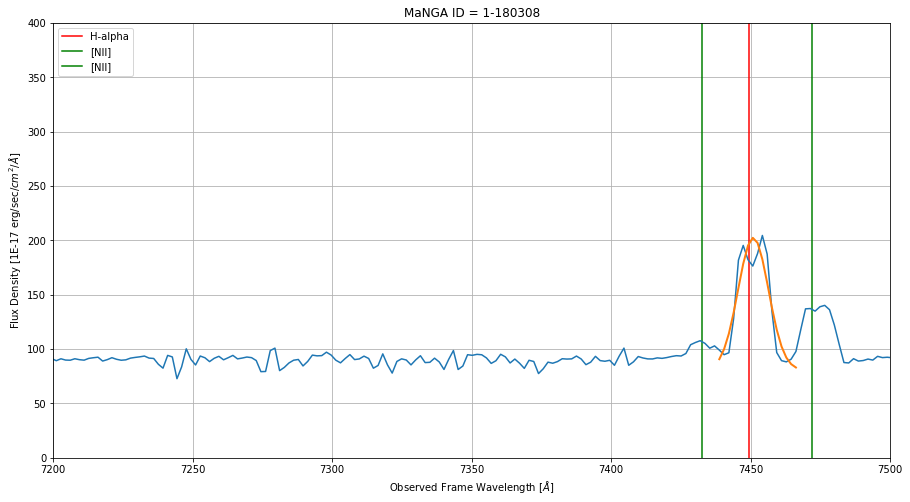

wave_slice difference 28.768345599643
amp 45.78904734606774
mean 7348.5176137613935
sigma 2.0587514577327437
base 120.00662380060038
base_total 93.42243743419185
new_amp 165.79567114666813

Flux + continuum = 3688.687533634852
Continuum 2687.6089668678565
Flux = 1001.0785667669957


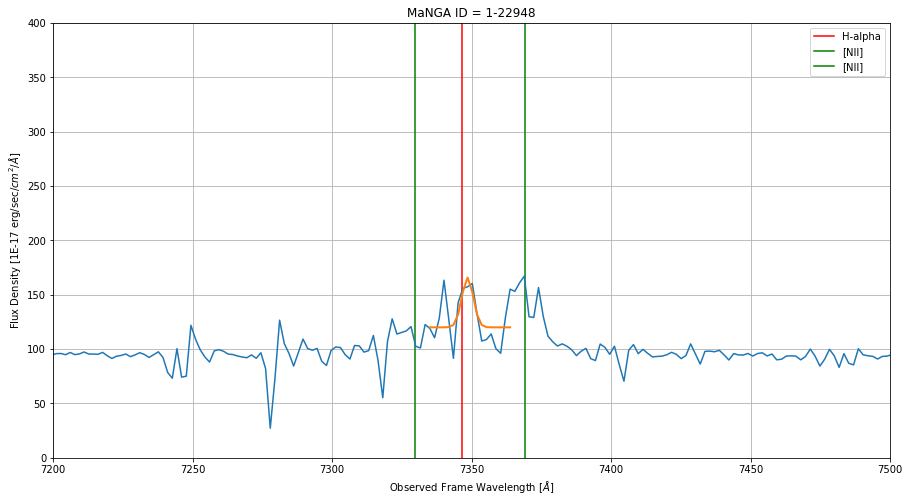

wave_slice difference 27.310894019732586
amp 131.9571600628857
mean 7415.08518274065
sigma 2.851424034525942
base 170.70924656045986
base_total 97.18061657496814
new_amp 302.66640662334555

Flux + continuum = 5605.3610096005505
Continuum 2654.0895200512227
Flux = 2951.2714895493277


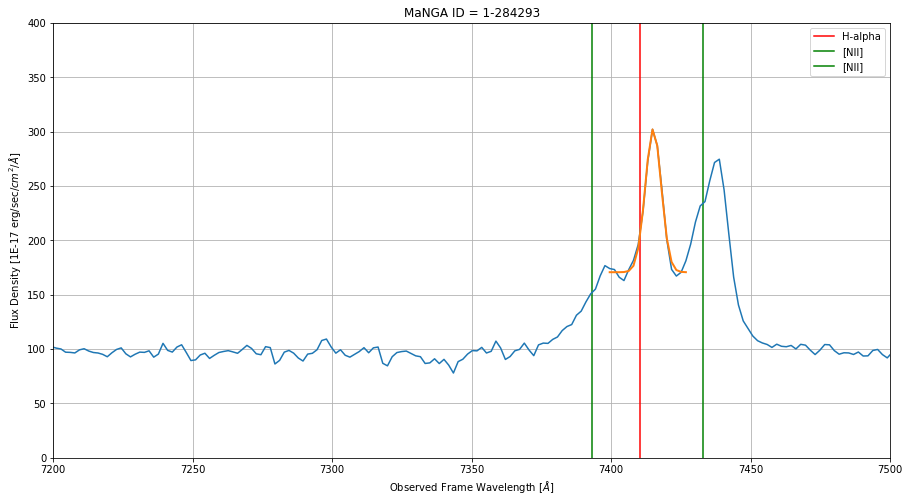

In [27]:
for plateifu in outlier:
        data = fits.open(f'/Volumes/WD_External/All_Objects/manga-{plateifu[0]}-LOGCUBE.fits.gz')
        mangaid = data[0].header['MANGAID']

        flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

        ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

        mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))

        do_not_use = (mask & 2**10) != 0 

        wave = data['WAVE'].data

        sumflux = spectrum_gen(flux, ivar)

        peak_ha = 6563 * (1 + plateifu[1])
        peak_6548 = 6548 * (1 + plateifu[1])
        peak_6583 = 6583 *(1 + plateifu[1])

        bound_ha = np.where(np.logical_and(wave > peak_ha-12, wave < peak_ha+19))
        
#         idx_6548 = np.where(wave < peak_6548)
#         idx_6583 = np.where(wave > peak_6583)
        
#         base_6548 = sumflux[idx_6548[0][-50] : idx_6548[0][-25]+1]
#         base_6583 = sumflux[idx_6583[0][25] : idx_6583[0][51]]
#         base_total = np.mean(base_6548 + base_6583)

        idx = np.where(np.logical_and(wave >= 7200, wave <= 7300))
#         print(idx[0])
        base_total = np.mean(sumflux[idx[0][0] : idx[0][-1]])

#         print(base_total)
        
#         print('6548', idx_6548[0], len(idx_6548[0]))
#         print('6583', idx_6583[0], len(idx_6583[0]))

        lb_ha = bound_ha[0][0]
        ub_ha = bound_ha[0][-1]

        sumflux_slice_ha = sumflux[lb_ha : ub_ha]

        wave_slice_ha = wave[lb_ha : ub_ha]
        print('wave_slice difference', wave_slice_ha[-1] - wave_slice_ha[0])

        amp_ha = max(sumflux_slice_ha)
        mean_ha = peak_ha
        sigma_ha = np.std(wave_slice_ha)
#         base_ha = np.mean(sumflux[idx_6548[0][-50] : idx_6548[0][-1]+1] 
#                                            + sumflux[idx_6583[0][0] : idx_6583[0][50]]) 
                  #min(sumflux_slice_ha)

        p0_ha = [amp_ha, mean_ha, sigma_ha, base_total]

        popt_ha, pcov_ha = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, p0 = p0_ha)
        
        print('amp', popt_ha[0])
        print('mean', popt_ha[1])
        print('sigma', popt_ha[2])
        print('base', popt_ha[3])
        print('base_total', base_total)
        new_amp = popt_ha[0]+popt_ha[3]
        print('new_amp', new_amp)
        print()


#         area = quad(gaussian, wave_slice_ha[0], wave_slice_ha[-1], args = (new_amp,
#                                                                            popt_ha[1],
#                                                                            sigma_ha,
#                                                                            base_total))
        
        area = quad(gaussian, wave_slice_ha[0], wave_slice_ha[-1], args = (popt_ha[0],
                                                                           popt_ha[1],
                                                                           popt_ha[2],
                                                                           popt_ha[3]))
        
        print('Flux + continuum =', area[0])

        continuum = (wave_slice_ha[-1] - wave_slice_ha[0]) * base_total
        
        print('Continuum', continuum)

        subtracted_area = area[0] - continuum

        print('Flux =', subtracted_area)
        
        fwhm_kms = (popt_ha[2] * c * 2.355) / l_ha

        writer.writerow([mangaid, plateifu[0], plateifu[1], subtracted_area, fwhm_kms])
        
#         popt, pcov = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, 
#                                p0 = [amp_ha, mean_ha, sigma_ha, base_ha])

        plt.figure(figsize = (15,8))
        plt.grid()
        plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
        plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
        plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
        plt.legend()
        plt.xlim(7200, 7500)
        plt.ylim(0,400)
        plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
        plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
        plt.title(f'MaNGA ID = {mangaid}')

        plt.plot(wave, sumflux)

        plt.plot(wave_slice_ha, gaussian(wave_slice_ha, *popt_ha), linewidth = 2)
#         plt.plot(wave_slice_ha, gaussian(wave_slice_ha, 
#                                          popt_ha[0], popt_ha[1], popt_ha[2], base_total), linewidth = 2)


        plt.show()

wave_slice difference 28.609804315932706
amp 47.17847502620593
mean 7307.66540446836
sigma 7.071691469071165
base 101.73276723660844
new_amp 148.91124226281437

Flux + continuum = 3708.229321776134
Continuum 2910.5545631576974
Flux = 797.6747586184365


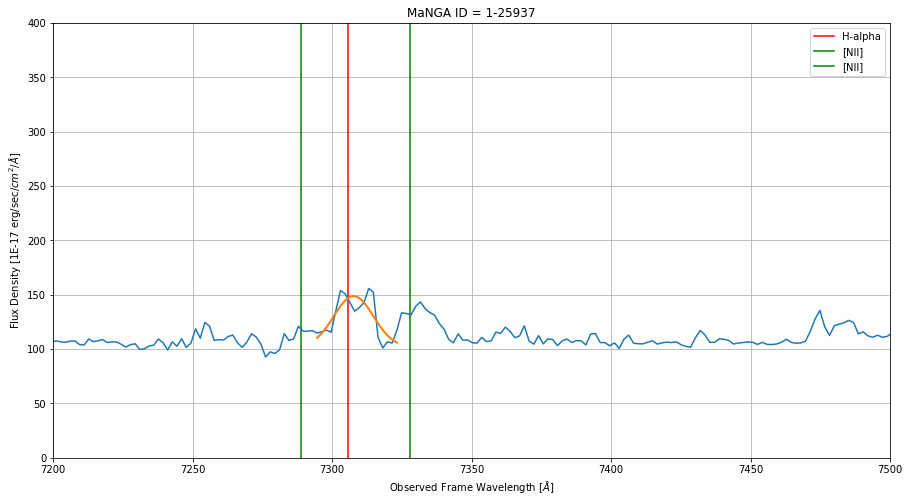

wave_slice difference 29.027851144792294
amp 66.06268101467771
mean 7414.189573474906
sigma 8.630081614617026
base 98.99053939980078
new_amp 165.0532204144785

Flux + continuum = 4163.30171994391
Continuum 2873.482642440114
Flux = 1289.819077503796


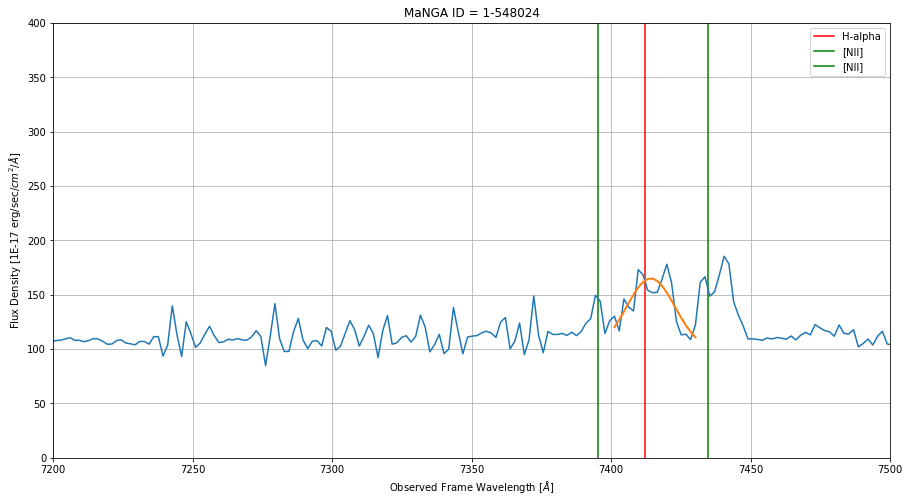

wave_slice difference 28.662554092501523
amp 182.4174775894754
mean 7320.218136869582
sigma 6.661160580848401
base 107.61033613533021
new_amp 290.0278137248056

Flux + continuum = 6007.489808225245
Continuum 3084.3870803911736
Flux = 2923.102727834071


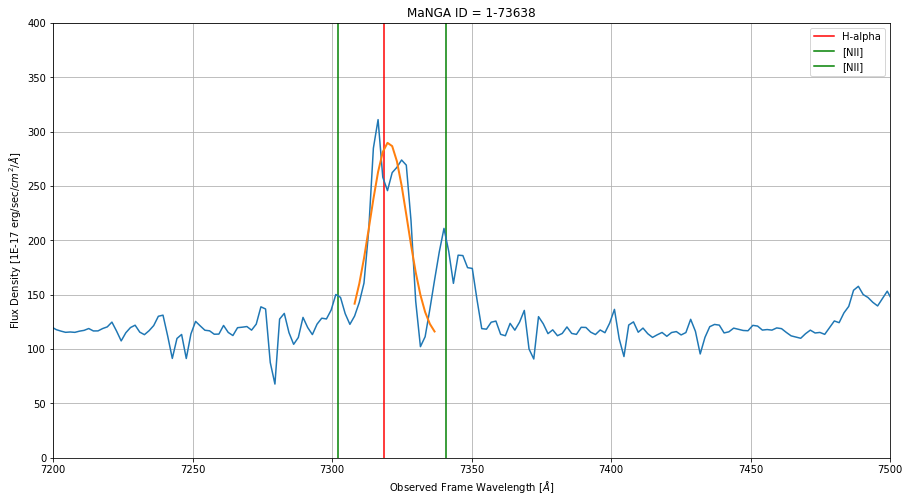

In [28]:
for plateifu in problems:
        data = fits.open(f'/Volumes/WD_External/All_Objects/manga-{plateifu[0]}-LOGCUBE.fits.gz')
        mangaid = data[0].header['MANGAID']

        flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

        ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

        mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))

        do_not_use = (mask & 2**10) != 0 

        wave = data['WAVE'].data

        sumflux = spectrum_gen(flux, ivar)

        peak_ha = 6563 * (1 + plateifu[1])
        peak_6548 = 6548 * (1 + plateifu[1])
        peak_6583 = 6583 *(1 + plateifu[1])

        bound_ha = np.where(np.logical_and(wave > peak_ha-12, wave < peak_ha+20))
        
        idx_6548 = np.where(wave < peak_6548)
        idx_6583 = np.where(wave > peak_6583)
        
        base_6548 = sumflux[idx_6548[0][-50] : idx_6548[0][-1]+1]
        base_6583 = sumflux[idx_6583[0][0] : idx_6583[0][50]]
        base_total = np.mean(base_6548 + base_6583)
#         print(base_total)
        
#         print('6548', idx_6548[0], len(idx_6548[0]))
#         print('6583', idx_6583[0], len(idx_6583[0]))

        lb_ha = bound_ha[0][0]
        ub_ha = bound_ha[0][-1]

        sumflux_slice_ha = sumflux[lb_ha : ub_ha]

        wave_slice_ha = wave[lb_ha : ub_ha]
        print('wave_slice difference', wave_slice_ha[-1] - wave_slice_ha[0])

        amp_ha = max(sumflux_slice_ha)
        mean_ha = peak_ha
        sigma_ha = np.std(wave_slice_ha)
#         base_ha = np.mean(sumflux[idx_6548[0][-50] : idx_6548[0][-1]+1] 
#                                            + sumflux[idx_6583[0][0] : idx_6583[0][50]]) 
                  #min(sumflux_slice_ha)

        p0_ha = [amp_ha, mean_ha, sigma_ha, base_total]

        popt_ha, pcov_ha = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, p0 = p0_ha)
        
        print('amp', popt_ha[0])
        print('mean', popt_ha[1])
        print('sigma', popt_ha[2])
        print('base', popt_ha[3])
        new_amp = popt_ha[0]+popt_ha[3]
        print('new_amp', new_amp)
        print()


#         area = quad(gaussian, wave_slice_ha[0], wave_slice_ha[-1], args = (new_amp,
#                                                                            popt_ha[1],
#                                                                            sigma_ha,
#                                                                            base_total))
        
        area = quad(gaussian, wave_slice_ha[0], wave_slice_ha[-1], args = (popt_ha[0],
                                                                           popt_ha[1],
                                                                           popt_ha[2],
                                                                           popt_ha[3]))
        
        print('Flux + continuum =', area[0])

        continuum = (wave_slice_ha[-1] - wave_slice_ha[0]) * popt_ha[3]
        
        print('Continuum', continuum)

        subtracted_area = area[0] - continuum

        print('Flux =', subtracted_area)
        
        fwhm_kms = (popt_ha[2] * c * 2.355) / l_ha

        writer.writerow([mangaid, plateifu[0], plateifu[1], subtracted_area, fwhm_kms])
        
#         popt, pcov = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, 
#                                p0 = [amp_ha, mean_ha, sigma_ha, base_ha])

        plt.figure(figsize = (15,8))
        plt.grid()
        plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
        plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
        plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
        plt.legend()
        plt.xlim(7200, 7500)
        plt.ylim(0,400)
        plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
        plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
        plt.title(f'MaNGA ID = {mangaid}')

        plt.plot(wave, sumflux)

        plt.plot(wave_slice_ha, gaussian(wave_slice_ha, *popt_ha), linewidth = 2)

        plt.show()

In [29]:
f.close()

In [30]:
# header = ['mangaid', 'plateifu', 'nsa_z', 'flux']
# with open('ha_list2.csv', 'w', encoding='UTF8', newline='') as f:
#     writer = csv.writer(f)
    
#     writer.writerow(header)
#     for plateifu in ha_list2:
#     #     print(plateifu)
#         data = fits.open(f'/Volumes/WD_External/MaNGA_Sample_with_[OIII]/manga-{plateifu[0]}-LOGCUBE.fits.gz')
#         mangaid = data[0].header['MANGAID']

#         flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

#         ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

#         mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))

#         do_not_use = (mask & 2**10) != 0 

#         wave = data['WAVE'].data

#         sumflux = spectrum_gen(flux, ivar)

#         peak_ha = 6563 * (1 + plateifu[1])
#         peak_6548 = 6548 * (1 + plateifu[1])
#         peak_6583 = 6583 *(1 + plateifu[1])
#     #     print(peak) 
#         bound_ha = np.where(np.logical_and(wave > peak_ha-10, wave < peak_ha+15))
#         bound_6548 = np.where(np.logical_and(wave > peak_6548-10, wave < peak_6548+10))
#         bound_6583 = np.where(np.logical_and(wave > peak_6583-10, wave < peak_6583+15))

#     #     print('bound', bound_6548, bound_6583)

#         lb_ha = bound_ha[0][0]
#         ub_ha = bound_ha[0][-1]

#         lb_6548 = bound_6548[0][0]
#         ub_6548 = bound_6548[0][-1] 

#         lb_6583 = bound_6583[0][0]
#         ub_6583 = bound_6583[0][-1] 

#     #     print(lb_6548, ub_6548, lb_ha, ub_ha, lb_6583, ub_6583)
#     #     print(wave[lb_6548], wave[ub_6548], wave[lb_ha], wave[ub_ha], wave[lb_6583], wave[ub_6583])

#         sumflux_slice_ha = sumflux[lb_ha : ub_ha]
#         sumflux_slice_6548 = sumflux[lb_6548 : ub_6548]
#         sumflux_slice_6583 = sumflux[lb_6583 : ub_6583]

#     #     sumflux_slice = sumflux[lb_6548 : ub_6583]

#     #     print('sumflux_slice',sumflux_slice)

#         wave_slice_ha = wave[lb_ha : ub_ha]
#         wave_slice_6548 = wave[lb_6548 : ub_6548]
#         wave_slice_6583 = wave[lb_6583 : ub_6583]

#     #     wave_slice = wave[lb_6548 : ub_6583]

#     #     print('wave_slice', wave_slice)

#         amp_ha = max(sumflux_slice_ha)
#         mean_ha = peak_ha
#         sigma_ha = np.std(wave_slice_ha)
#         base_ha = min(sumflux_slice_ha)

#         amp_6548 = max(sumflux_slice_6548)
#         mean_6548 = peak_6548
#         sigma_6548 = np.std(wave_slice_6548)
#         base_6548 = min(sumflux_slice_6548)

#         amp_6583 = max(sumflux_slice_6583)
#         mean_6583 = peak_6583
#         sigma_6583 = np.std(wave_slice_6583)
#         base_6583 = min(sumflux_slice_6583)

#     #     base = min(sumflux_slice)

#     #     p0_ = [amp_ha, amp_6548, amp_6583,
#     #            mean_ha, mean_6548, mean_6583,
#     #            sigma_ha, sigma_6548, sigma_6583,
#     #            base]

#         p0_ha = [amp_ha, mean_ha, sigma_ha, base_ha]
#         p0_6548 = [amp_6548, mean_6548, sigma_6548, base_6548]
#         p0_6583 = [amp_6583, mean_6583, sigma_6583, base_6583]

#         popt_ha, pcov_ha = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, p0 = p0_ha)
#         popt_6548, pcov_6548 = curve_fit(gaussian, wave_slice_6548, sumflux_slice_6548, p0 = p0_6548)
#         popt_6583, pcov_6583 = curve_fit(gaussian, wave_slice_6583, sumflux_slice_6583, p0 = p0_6583)

#         area = quad(gaussian, wave_slice_ha[0], wave_slice_ha[-1], args = (popt_ha[0],
#                                                                            popt_ha[1],
#                                                                            popt_ha[2],
#                                                                            popt_ha[3]))
#         print(plateifu[0])
#         print('Integrated area =', area[0])

#         continuum = (wave_slice_ha[-1] - wave_slice_ha[0]) * popt_ha[-1]

#         subtracted_area = area[0] - continuum

#         print('Subtracted area =', subtracted_area)

#         trapezium_area = area_finder(wave_slice_ha, sumflux_slice_ha)

#         print('Trapezium area =', trapezium_area)
        
#         writer.writerow([mangaid, plateifu[0], plateifu[1], subtracted_area])

#     #     print('popt', popt)
#     #     print('pcov', pcov)

#     # #     print('amp', amp)
#     # #     print('sigma', sigma)
#     # #     print('base', base)

#     #     popt, pcov = curve_fit(gaussian, wave_slice, sumflux_slice, p0 = [amp, mean, sigma, base])
#     # #     print('popt', popt)
#     # #     print('pcov', pcov)

#     # #     plt.plot(wave_slice, gaussian(wave_slice, *popt))
#     # #     plt.show()

#     # #     print(sumflux, len(sumflux))

# #         plt.figure(figsize = (15,8))
# #         plt.grid()
# #         plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
# #         plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
# #         plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
# #         plt.legend()
# #     #     plt.axvline(wave[lb], color = 'deeppink')
# #     #     plt.axvline(wave[ub], color = 'deeppink')
# #     #     plt.xlim(6300,6700)
# #         plt.xlim(7250, 7550)
# #     #     plt.xlim(wave[lb]-10, wave[ub]+10)
# #         plt.ylim(0,400)
# #         plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
# #         plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
# #         plt.title(f'MaNGA ID = {mangaid}')

# #         plt.axvline(wave_slice_ha[0])
# #         plt.axvline(wave_slice_ha[-1])
# #         print(wave_slice_ha[-1] - wave_slice_ha[0])
# #         print(popt_ha)


# #         plt.plot(wave, sumflux)

# #         plt.plot(wave_slice_ha, gaussian(wave_slice_ha, *popt_ha), linewidth = 2)
# #         plt.plot(wave_slice_6548, gaussian(wave_slice_6548, *popt_6548), linewidth = 2, color = 'red')
# #         plt.plot(wave_slice_6583, gaussian(wave_slice_6583, *popt_6583), linewidth = 2, color = 'red')

# #         plt.show()

In [31]:
# def gaussian_1_43214(x, amp, mean, sigma):
#     return (amp * np.exp(-(x-mean)**2 / (2*sigma**2)))

In [32]:
# def three_gaussian(x, 
#                    a_ha, a_6548, a_6583,
#                    m_ha, m_6548, m_6583,
#                    s_ha, s_6548, s_6583,
#                    base):
#     gaussian_ha = gaussian_1_43214(x, amp_ha, mean_ha, sigma_ha)
#     gaussian_6548 = gaussian_1_43214(x, amp_6548, mean_6548, sigma_6548)
#     gaussian_6583 = gaussian_1_43214(x, amp_6583, mean_6583, sigma_6583)
#     return gaussian_ha + gaussian_6548 + gaussian_6583 + base

In [33]:
# for plateifu in obj1_43214:
# #     print(plateifu)
#     data = fits.open(f'/Volumes/WD_External/MaNGA_Sample_with_[OIII]/manga-{plateifu[0]}-LOGCUBE.fits.gz')
#     mangaid = data[0].header['MANGAID']
    
#     flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

#     ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

#     mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))
    
#     do_not_use = (mask & 2**10) != 0 
    
#     wave = data['WAVE'].data
    
#     sumflux = spectrum_gen(flux, ivar)
    
#     peak_ha = 6563*(1+plateifu[1])
#     peak_6548 = 6548*(1+plateifu[1])
#     peak_6583 = 6583*(1+plateifu[1])

#     bound_ha = np.where(np.logical_and(wave > (peak_ha-10), wave < (peak_ha+10)))
#     bound_6548 = np.where(np.logical_and(wave > (peak_6548-10), wave < (peak_6548+10)))
#     bound_6583 = np.where(np.logical_and(wave > (peak_6583-10), wave < (peak_6583+10)))
        
#     lb_ha = bound_ha[0][0]
#     ub_ha = bound_ha[0][-1]
    
#     lb_6548 = bound_6548[0][0]
#     ub_6548 = bound_6548[0][-1] 
    
#     lb_6583 = bound_6583[0][0]
#     ub_6583 = bound_6583[0][-1] 
    
#     print(lb_6548, ub_6548, lb_ha, ub_ha, lb_6583, ub_6583)
    
#     sumflux_slice_ha = sumflux[lb_ha : ub_ha]
#     sumflux_slice_6548 = sumflux[lb_6548 : ub_6548]
#     sumflux_slice_6583 = sumflux[lb_6583 : ub_6583]
    
#     sumflux_slice = sumflux[lb_6548 : ub_6583]
    
#     wave_slice_ha = wave[lb_ha : ub_ha]
#     wave_slice_6548 = wave[lb_6548 : ub_6548]
#     wave_slice_6583 = wave[lb_6583 : ub_6583]
    
#     wave_slice = wave[lb_6548 : ub_6583]
        
#     amp_ha = max(sumflux_slice_ha)
#     mean_ha = peak_ha
#     sigma_ha = np.std(wave_slice_ha)
    
#     amp_6548 = max(sumflux_slice_6548)
#     mean_6548 = peak_6548
#     sigma_6548 = np.std(wave_slice_6548)
    
#     amp_6583 = max(sumflux_slice_6583)
#     mean_6583 = peak_6583
#     sigma_6583 = np.std(wave_slice_6583)

#     base = min(sumflux_slice)
    
#     p0_ = [amp_ha, amp_6548, amp_6583,
#            mean_ha, mean_6548, mean_6583,
#            sigma_ha, sigma_6548, sigma_6583,
#            base]
    
#     popt, pcov = curve_fit(three_gaussian, wave_slice, sumflux_slice, p0 = p0_)

#     plt.figure(figsize = (15,8))
#     plt.grid()
#     plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
#     plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
#     plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
#     plt.legend()

#     plt.xlim(7200, 7500)
#     plt.ylim(0,1200)
    
#     plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
#     plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
#     plt.title(f'MaNGA ID = {mangaid}')
    
#     plt.plot(wave, sumflux)
#     plt.plot(wave_slice, three_gaussian(wave_slice, *popt), linewidth = 2)
    
#     plt.show()

In [34]:
# for plateifu in obj1_43214:
# #     print(plateifu)
#     data = fits.open(f'/Volumes/WD_External/MaNGA_Sample_with_[OIII]/manga-{plateifu[0]}-LOGCUBE.fits.gz')
#     mangaid = data[0].header['MANGAID']
    
#     flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

#     ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

#     mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))
    
#     do_not_use = (mask & 2**10) != 0 
    
#     wave = data['WAVE'].data
    
#     sumflux = spectrum_gen(flux, ivar)
    
#     peak_ha = 6563 * (1 + plateifu[1])
#     peak_6548 = 6548 * (1 + plateifu[1])
#     peak_6583 = 6583 *(1 + plateifu[1])

#     bound_ha = np.where(np.logical_and(wave > peak_ha-10, wave < peak_ha+15))
#     bound_6548 = np.where(np.logical_and(wave > peak_6548-30, wave < peak_6548+10))
#     bound_6583 = np.where(np.logical_and(wave > peak_6583-10, wave < peak_6583+30))
        
#     lb_ha = bound_ha[0][0]
#     ub_ha = bound_ha[0][-1]
    
#     lb_6548 = bound_6548[0][0]
#     ub_6548 = bound_6548[0][-1] 
    
#     lb_6583 = bound_6583[0][0]
#     ub_6583 = bound_6583[0][-1] 
    
#     sumflux_slice_ha = sumflux[lb_ha : ub_ha]
#     sumflux_slice_6548 = sumflux[lb_6548 : ub_6548]
#     sumflux_slice_6583 = sumflux[lb_6583 : ub_6583]

#     wave_slice_ha = wave[lb_ha : ub_ha]
#     wave_slice_6548 = wave[lb_6548 : ub_6548]
#     wave_slice_6583 = wave[lb_6583 : ub_6583]
    
#     amp_ha = max(sumflux_slice_ha)
#     mean_ha = peak_ha
#     sigma_ha = np.std(wave_slice_ha)
#     base_ha = min(sumflux_slice_ha)
    
#     amp_6548 = max(sumflux_slice_6548)
#     mean_6548 = peak_6548
#     sigma_6548 = np.std(wave_slice_6548)
#     base_6548 = min(sumflux_slice_6548)
    
#     amp_6583 = max(sumflux_slice_6583)
#     mean_6583 = peak_6583
#     sigma_6583 = np.std(wave_slice_6583)
#     base_6583 = min(sumflux_slice_6583)

#     p0_ha = [amp_ha, mean_ha, sigma_ha, base_ha]
#     p0_6548 = [amp_6548, mean_6548, sigma_6548, base_6548]
#     p0_6583 = [amp_6583, mean_6583, sigma_6583, base_6583]
    
#     popt_ha, pcov_ha = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, p0 = p0_ha)
#     popt_6548, pcov_6548 = curve_fit(gaussian, wave_slice_6548, sumflux_slice_6548, p0 = p0_6548)
#     popt_6583, pcov_6583 = curve_fit(gaussian, wave_slice_6583, sumflux_slice_6583, p0 = p0_6583)
    
#     plt.figure(figsize = (15,8))
#     plt.grid()
#     plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
#     plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
#     plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
#     plt.legend()

#     plt.xlim(7200, 7500)
#     plt.ylim(0,1200)
    
#     plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
#     plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
#     plt.title(f'MaNGA ID = {mangaid}')
    
#     plt.plot(wave, sumflux)
    
#     plt.plot(wave_slice_ha, gaussian(wave_slice_ha, *popt_ha), linewidth = 2)
#     plt.plot(wave_slice_6548, gaussian(wave_slice_6548, *popt_6548), linewidth = 3, color = 'purple')
#     plt.plot(wave_slice_6583, gaussian(wave_slice_6583, *popt_6583), linewidth = 3, color = 'purple')
    
#     plt.show()